# Performance comparisons

In memory and out of memory, using dask.

In [1]:
# Change dir to repo root if running from repo (rather than pip installed)
# (Assuming running from [repo]/notes/)
import os
os.chdir('../')

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from typing import Tuple

from incremental_trees.trees import StreamingRFC

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import dask_ml
import dask_ml.datasets
from dask_ml.wrappers import Incremental
from dask.distributed import Client, LocalCluster
from dask_ml.model_selection import train_test_split as dask_tts

import dask as dd
import pandas as pd

In [3]:
# Settings
MAX_ESTIMATORS = 60  # Lower to run faster

In [4]:
# Prepare dask cluster
cluster = LocalCluster(processes=False,
                       n_workers=2,
                       threads_per_worker=2,
                       scheduler_port=8383,
                       diagnostics_port=8484)
client = Client(cluster)

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available


# Synthetic data, in memory

Compare increasing estimators with RandomForest (using warm_start) against Incremental StreamingRFC (dask handles .partial_fit).



In [5]:
x, y = dask_ml.datasets.make_blobs(n_samples=1e5,
                                   chunks=1e4,
                                   random_state=0,
                                   n_features=40,
                                   centers=2,
                                   cluster_std=100)

x_dd = dd.dataframe.from_array(x, 
                               chunksize=1e4)
y_dd = dd.dataframe.from_array(y,
                               chunksize=1e4)

x_pd = pd.DataFrame(x.persist().compute())
y_pd = pd.DataFrame(y.persist().compute())

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available


In [6]:
x_pd.memory_usage(deep=True).sum() / 1024 /1024

30.517654418945312

### Standard random forest

In [7]:
def score(mod, 
          train: Tuple[np.array, np.array],
          test: Tuple[np.array, np.array],
          pr=False) -> Tuple[float, float]:
    """
    Return ROC auc on x_train and x_test (from caller) on mod. Print if requested.
    """
    y_pred_train_proba = mod.predict_proba(train[0])[:, 1]
    y_pred_test_proba = mod.predict_proba(test[0])[:, 1]

    roc_train = roc_auc_score(train[1], y_pred_train_proba)
    roc_test = roc_auc_score(test[1], y_pred_test_proba)
    if pr:
        print(f"n_ests: {len(rfc.estimators_)}")
        print(f'Train AUC: {roc_train}')
        print(f'Test AUC: {roc_test}')
        
    return roc_train, roc_test


def score_dask(mod, 
               train: Tuple[np.array, np.array],
               test: Tuple[np.array, np.array],
               pr=False) -> Tuple[float, float]:
    """
    Score model using available dask metric (accuracy)
    """
    roc_train = mod.score(train[0], train[1])
    roc_test = mod.score(test[0], test[1])
    if pr:
        print(f"n_ests: {len(rfc.estimators_)}")
        print(f'Train AUC: {roc_train}')
        print(f'Test AUC: {roc_test}')
        
    return roc_train, roc_test


def multiple_fit(x: np.array, y: np.array,
                 steps=np.arange(1, 101, 2),
                 sample: int=1):
    """
    Fit a random forest model with an increasing number of estimators.
    
    This version doesn't use warm start and refits the model from scratch each iteration.
    This is for the sake of comparing timings to dask function below.
    
    :param steps: Range to iterate over. Sets total number of estimators that will be fit in model
                  after each iteration. Should be range with constant step size.
    :param sample: Proportion of randomly sampled training data to use on each partial_fit call.
                   If sample = 1, all training data is used on each interation,
                   so should behave as standard random forest. Default = 1 (100%).
    """
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                        test_size=0.25,
                                                        random_state=1)
    
    train_scores = []
    test_scores = []
    for s in steps:
        
        # Fit full model on each iteration
        rfc = RandomForestClassifier(warm_start=False)
        
        # Fit model with these n ests
        rfc.set_params(n_estimators=s)
        rfc.fit(x_train, y_train)
        
        tr_score, te_score = score(rfc, 
                                   train=(x_train, y_train),
                                   test=(x_test, y_test),
                                   pr=False)
        
        train_scores.append(tr_score)
        test_scores.append(te_score)
    
    return rfc, train_scores, test_scores


def plot_auc(steps, train_scores, test_scores):
    """
    Plot the train and test auc scores vs total number of model estimators
    """
    
    fig = plt.figure(figsize=(4, 4))
    plt.plot(steps, train_scores)
    plt.plot(steps, test_scores)
    plt.xlabel('n_estimators')
    plt.ylabel('auc')
    plt.legend(['train', 'test'])

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available


In [8]:
steps = np.arange(1, MAX_ESTIMATORS, 4)

CPU times: user 3min 30s, sys: 1.02 s, total: 3min 31s
Wall time: 3min 37s
With 57: 1.0 | 0.6337612567122703


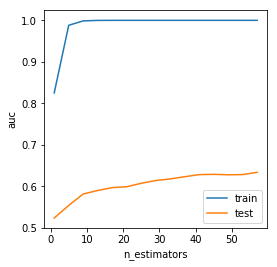

In [9]:
rfc = RandomForestClassifier(warm_start=True)

%time rfc, train_scores, test_scores = multiple_fit(x_pd.values, y_pd.values.squeeze(), steps=steps)

print(f"With {len(rfc.estimators_)}: {train_scores[-1]} | {test_scores[-1]}")
plot_auc(steps, train_scores, test_scores)

## Single incremental forest specs

In [10]:
x_train, x_test, y_train, y_test = dask_tts(x, y, 
                                            test_size=0.25)

x_train.chunks

((7500, 7500, 7500, 7500, 7500, 7500, 7500, 7500, 7500, 7500), (40,))

#### Incremental forest
1 estimator per subset, 10 % per chunk, 1 pass through data.


In [11]:
srfc = Incremental(StreamingRFC(n_estimators_per_chunk=1,
                                max_n_estimators=np.inf))

srfc.fit(x_train, y_train,
         classes=[0, 1])

tr_score, te_score = score(srfc, 
                           train=(x_train, y_train),
                           test=(x_test, y_test),
                           pr=True)

distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
distributed.comm.tcp - WARNING - Could not set timeout on TCP stream: [Errno 92] Protocol not available
/mnt/s/OneDrive/Matlab/dask tests/IncrementalTrees/incremental_trees/trees.py:199: RuntimeWarning: invalid value encountered in true_divide
  norm_prob = preds / counts


n_ests: 57
Train AUC: 0.6658850266643547
Test AUC: 0.566714711139625


#### Incremental forest
20 estimators per subset (different features), 10 % per chunk, 1 pass through data.

In [12]:
srfc = Incremental(StreamingRFC(n_estimators_per_chunk=20,
                                max_n_estimators=np.inf))

srfc.fit(x_train, y_train,
         classes=[0, 1])

tr_score, te_score = score(srfc, 
                           train=(x_train, y_train),
                           test=(x_test, y_test),
                           pr=True)

n_ests: 57
Train AUC: 0.8403617676637958
Test AUC: 0.6507955222895951


#### Forest of partial decision trees
1 estimator per subset with all features, 10 % per chunk, 1 pass through data.

In [13]:
srfc = Incremental(StreamingRFC(n_estimators_per_chunk=1,
                                max_n_estimators=np.max(steps),
                                max_features=x.shape[1]))

srfc.fit(x_train, y_train,
         classes=[0, 1])

tr_score, te_score = score(srfc, 
                           train=(x_train, y_train),
                           test=(x_test, y_test),
                           pr=True)

n_ests: 57
Train AUC: 0.6702321483770426
Test AUC: 0.5732644847212355


#### Forest of partial decision trees
20 estimator per subset with all features, 10 % per chunk, 1 pass through data.

Extra estimators shouldn't help here?

In [14]:
srfc = Incremental(StreamingRFC(n_estimators_per_chunk=20,
                                max_n_estimators=np.max(steps),
                                max_features=x.shape[1]))

srfc.fit(x_train, y_train,
         classes=[0, 1])

tr_score, te_score = score(srfc, 
                           train=(x_train, y_train),
                           test=(x_test, y_test),
                           pr=True)

n_ests: 57
Train AUC: 0.7542754850739607
Test AUC: 0.6273808721369764


### n estimators per chunk vs performance

Effect of increasing estimators per subset (with different set ups)

Function here add Incremental to supplied model, and uses .fit to refit the full model in each iteration.

The other functions (above and in PerformanceComparisons.ipynb) do incremental fits using warm start (either directly or via .partial_fit). 

This means the timing information cannot be directly compared!

In [15]:
def multiple_dask_fit(x: np.ndarray, y:np.ndarray,
                      steps=np.arange(1, 101, 2),
                      **kwargs) -> None:
    
    """
    Fit increasing number of estimators using .partial_fit on a subsample of the training data.
    Uses Dask by adding Incremental to model and calling fit. This refits the whole model one each
    iteration, so will be slower than the other test functions. Timing this function can only be compared
    to other calls of this function.
    
    The data passed to the Random forest fit by partial_fit is handled by dask and is sequential batches
    of data, rather than random samples (as used by inc_partial_fit in PerformanceComparisons.ipynb).
    
    StreamingRFC.n_estimators: Number of estimators that will be fit in each step. Set from first
                               difference in range (ie. range[1]-range[0])
    StreamingRFC.max_n_estimators: Limit on number of estimators than will be fit in model. Should >
                                   range[-1].
    
    :param steps: Range to iterate over. Sets total number of estimators that will be fit in model
                  after each iteration. Should be range with constant step size.
    """
    
   
    x_train, x_test, y_train, y_test = dask_tts(x, y, 
                                               test_size=0.25)
    
    n_train = x_train.shape[0]
    
    train_scores = []
    test_scores = []
    for s in steps:
        
        # Create fresh model each iteration
        srfc_ = StreamingRFC(n_estimators_per_chunk=s,
                             max_n_estimators=np.inf,
                             **kwargs)
 
           
        # Add Incremental
        srfc_ = Incremental(srfc_)
        
        # Fit model with these n ests
        # From scratch each time
        srfc_.fit(x_train, y_train,
                  classes=[0, 1])
        
        tr_score, te_score = score(srfc_,
                                   train=(x_train, y_train),
                                   test=(x_test, y_test),
                                   pr=False)
        train_scores.append(tr_score)
        test_scores.append(te_score)
    
    return srfc_, train_scores, test_scores

#### Incremental forest
*range* estimators per subset (different features), 10 % per chunk, 1 pass through data.

In [16]:
steps = np.arange(1, MAX_ESTIMATORS, 6)

%time final_est, train_scores, test_scores = multiple_dask_fit(x, y, steps=steps)
print(f"With {len(final_est.estimators_)}: {train_scores[-1]} | {test_scores[-1]}")
plot_auc(steps, train_scores, test_scores)

RuntimeError: Cannot clone object StreamingRFC(bootstrap=True, class_weight=None, criterion='gini',
       max_depth=None, max_features='auto', max_leaf_nodes=None,
       max_n_estimators=inf, min_impurity_decrease=0.0,
       min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
       min_weight_fraction_leaf=0.0, n_estimators=1,
       n_estimators_per_chunk=1, n_jobs=None, oob_score=False,
       random_state=None, verbose=0, warm_start=True), as the constructor either does not set or modifies parameter n_estimators

NameError: name 'final_est' is not defined

#### Forest of partial decision trees
*range* estimators per subset with all features, 10 % per chunk, 1 pass through data.

In [ ]:
steps = np.arange(1, MAX_ESTIMATORS, 6)

%time final_est, train_scores, test_scores = multiple_dask_fit(x, y, steps=steps, max_features=x.shape[1])
print(f"With {len(final_est.estimators_)}: {train_scores[-1]} | {test_scores[-1]}")
plot_auc(steps, train_scores, test_scores)